## Importing Libraries

In [1]:
import nltk
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import string
import re
import numpy as np

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from collections import Counter
from string import punctuation

## Importing and analyzing the dataset 

In [2]:
twitters = pd.read_csv('training.txt', sep = '\t', names=['label', 'tweet'])

In [3]:
twitters.head()

,label,tweet
0,1,The Da Vinci Code book is just awesome.
1,1,this was the first clive cussler i've ever rea...
2,1,i liked the Da Vinci Code a lot.
3,1,i liked the Da Vinci Code a lot.
4,1,I liked the Da Vinci Code but it ultimatly did...


In [4]:
# check the number of positive vs. negative labeled tweets
pos = twitters['label'][twitters.label == 0]
neg = twitters['label'][twitters.label == 1]

print('number of positve tagged sentences is:  {}'.format(len(pos)))
print('number of negative tagged sentences is: {}'.format(len(neg)))
print('total length of the data is:            {}'.format(twitters.shape[0]))

number of positve tagged sentences is:  2975
number of negative tagged sentences is: 3943
total length of the data is:            6918


In [5]:
twitters.describe()

,label
count,6918.000000
mean,0.569962
std,0.495117
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [6]:
twitters.groupby('label').describe()

tweet                                  
      count unique                   top freq
label                                        
0      2975    559  I hate Harry Potter.   85
1      3943    732  I love Harry Potter.  167

In [7]:
# get a word count per sentence column
def word_count(sentence):
    return len(sentence.split())
    
twitters['word count'] = twitters['tweet'].apply(word_count)
twitters.head(10)

,label,tweet,word count
0,1,The Da Vinci Code book is just awesome.,8
1,1,this was the first clive cussler i've ever rea...,23
2,1,i liked the Da Vinci Code a lot.,8
3,1,i liked the Da Vinci Code a lot.,8
4,1,I liked the Da Vinci Code but it ultimatly did...,15
5,1,that's not even an exaggeration ) and at midni...,24
6,1,"I loved the Da Vinci Code, but now I want some...",14
7,1,"i thought da vinci code was great, same with k...",11
8,1,The Da Vinci Code is actually a good movie...,9
9,1,I thought the Da Vinci Code was a pretty good ...,11


## Data Visualization 

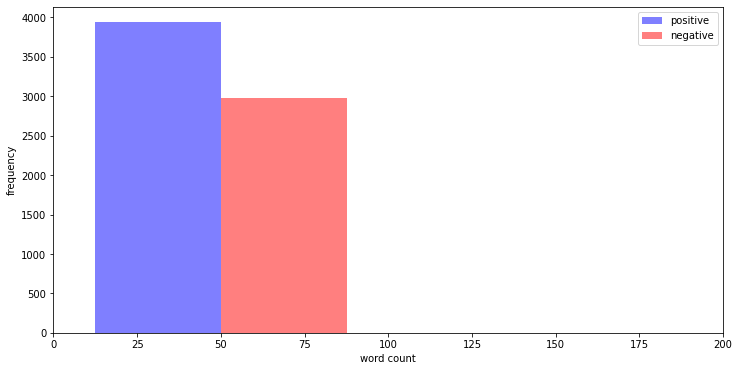

In [8]:
# plot word count distribution for both positive and negative sentiments
x = twitters['word count'][twitters.label == 1]
y = twitters['word count'][twitters.label == 0]
plt.figure(figsize=(12,6))
plt.xlim(0,200)
plt.xlabel('word count')
plt.ylabel('frequency')
g = plt.hist([x, y], color=['b','r'], alpha=0.5, label=['positive','negative'])
plt.legend(loc='upper right')

In [9]:
# get most common words in training dataset
all_words = []
for line in list(twitters['tweet']):
    words = line.split()
    for word in words:
        all_words.append(word.lower())
    
    
Counter(all_words).most_common(10)

[('i', 4559),
 ('the', 3221),
 ('and', 2148),
 ('harry', 2088),
 ('vinci', 2001),
 ('da', 1998),
 ('brokeback', 1996),
 ('code', 1628),
 ('love', 1540),
 ('is', 1512)]

In [10]:
# get top-10 words more frequent with positive labels in training dataset
pos_words = []
for line in list(twitters['tweet'][twitters.label == 1]):
    pwords = line.split()
    for pword in pwords:
        pos_words.append(pword.lower())
    
    
Counter(pos_words).most_common(10)

[('i', 3142),
 ('the', 1836),
 ('love', 1532),
 ('harry', 1085),
 ('vinci', 1000),
 ('da', 999),
 ('brokeback', 999),
 ('mission', 997),
 ('is', 987),
 ('and', 954)]

In [11]:
# get top-10 words more frequent with negative labels in training dataset
neg_words = []
for line in list(twitters['tweet'][twitters.label == 0]):
    nwords = line.split()
    for nword in nwords:
        neg_words.append(nword.lower())
    
    
Counter(neg_words).most_common(10)

[('i', 1417),
 ('the', 1385),
 ('and', 1194),
 ('harry', 1003),
 ('vinci', 1001),
 ('da', 999),
 ('brokeback', 997),
 ('code', 946),
 ('mountain', 716),
 ('hate', 571)]

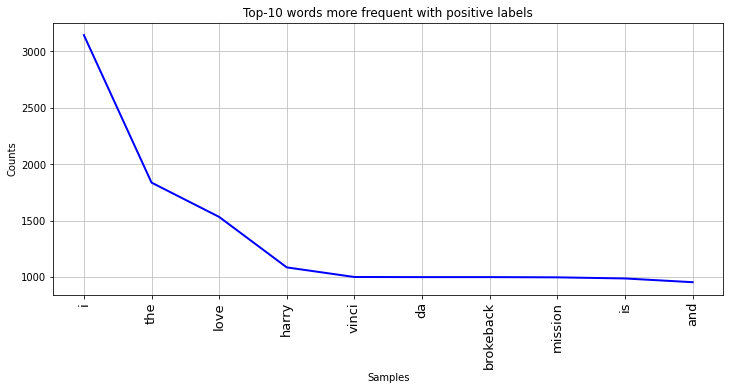

Text(0.5, 1.0, 'log-log plot of words frequency with positive labels')

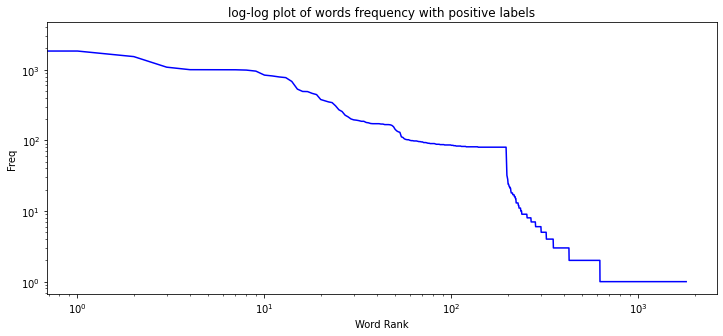

In [12]:
# plot word frequency distribution of first few words with positive labels
plt.figure(figsize=(12,5))
plt.title('Top-10 words more frequent with positive labels')
plt.xticks(fontsize=13, rotation=90)
fd = nltk.FreqDist(pos_words)
fd.plot(10,cumulative=False, color="blue")

# log-log plot with positive labels
word_counts = sorted(Counter(pos_words).values(), reverse=True)
plt.figure(figsize=(12,5))
plt.loglog(word_counts, linestyle='-', linewidth=1.5, color="blue")
plt.ylabel("Freq")
plt.xlabel("Word Rank")
plt.title('log-log plot of words frequency with positive labels')

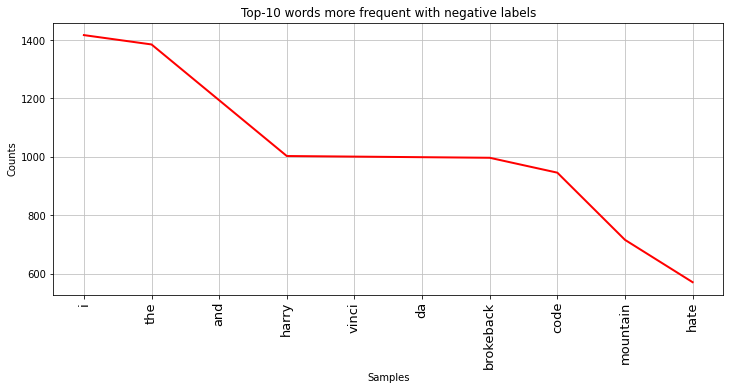

Text(0.5, 1.0, 'log-log plot of words frequency with negative labels')

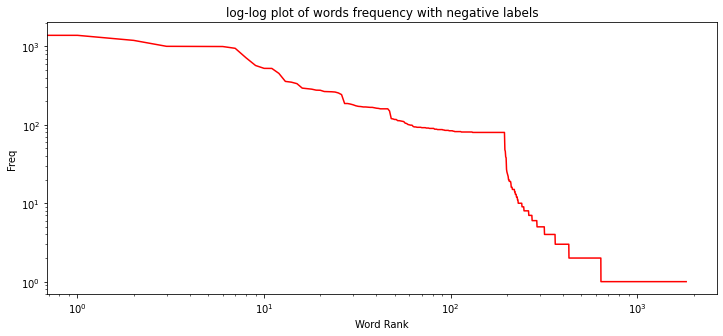

In [13]:
# plot word frequency distribution of first few words with negative labels
plt.figure(figsize=(12,5))
plt.title('Top-10 words more frequent with negative labels')
plt.xticks(fontsize=13, rotation=90)
fd = nltk.FreqDist(neg_words)
fd.plot(10,cumulative=False, color="red")

# log-log plot with negative labels
word_counts = sorted(Counter(neg_words).values(), reverse=True)
plt.figure(figsize=(12,5))
plt.loglog(word_counts, linestyle='-', linewidth=1.5, color="red")
plt.ylabel("Freq")
plt.xlabel("Word Rank")
plt.title('log-log plot of words frequency with negative labels')

## Data Pre-Processing 1: Text Cleaning

In [14]:
# helper function to clean tweets
def preprocess_twitters(twitt):
    # To lowercase
    twitt = twitt.lower()
    
    # Remove single space remaining at the front of the tweet.
    #twitt = twitt.lstrip(' ')
    
    # Remove HTML special entities (e.g. &amp;)
    twitt = re.sub(r'\&\w*;', '', twitt)
    
    #Convert @username to AT_USER
    twitt = re.sub('@[^\s]+','',twitt)
    
    # Remove tickers
    twitt = re.sub(r'\$\w*', '', twitt)
    
    # Remove hyperlinks
    twitt = re.sub(r'https?:\/\/.*\/\w*', '', twitt)
    
    # Remove hashtags
    twitt = re.sub(r'#\w*', '', twitt)
    
    # Remove Punctuation and split 's, 't, 've with a space for filter
    twitt = re.sub(r'[' + punctuation.replace('@', '') + ']+', ' ', twitt)
    
    # Remove words with 2 or fewer letters
    #twitt = re.sub(r'\b\w{1,2}\b', '', twitt)
    
    # Remove whitespace (including new line characters)
    twitt = re.sub(r'\s\s+', ' ', twitt) 
    
    # Remove characters beyond Basic Multilingual Plane (BMP) of Unicode:
    twitt = ''.join(c for c in twitt if c <= '\uFFFF') 
    
    return twitt

In [15]:
twitters['tweet'].head(5).apply(preprocess_twitters)

0              the da vinci code book is just awesome 
1    this was the first clive cussler i ve ever rea...
2                     i liked the da vinci code a lot 
3                     i liked the da vinci code a lot 
4    i liked the da vinci code but it ultimatly did...
Name: tweet, dtype: object

In [16]:
twitters.head()

,label,tweet,word count
0,1,The Da Vinci Code book is just awesome.,8
1,1,this was the first clive cussler i've ever rea...,23
2,1,i liked the Da Vinci Code a lot.,8
3,1,i liked the Da Vinci Code a lot.,8
4,1,I liked the Da Vinci Code but it ultimatly did...,15


In [17]:
twitters['tweet_preprocess'] = twitters['tweet'].apply(preprocess_twitters)

In [18]:
twitters.head()

,label,tweet,word count,tweet_preprocess
0,1,The Da Vinci Code book is just awesome.,8,the da vinci code book is just awesome
1,1,this was the first clive cussler i've ever rea...,23,this was the first clive cussler i ve ever rea...
2,1,i liked the Da Vinci Code a lot.,8,i liked the da vinci code a lot
3,1,i liked the Da Vinci Code a lot.,8,i liked the da vinci code a lot
4,1,I liked the Da Vinci Code but it ultimatly did...,15,i liked the da vinci code but it ultimatly did...


In [19]:
twitters['tweet_preprocess'].head()

0              the da vinci code book is just awesome 
1    this was the first clive cussler i ve ever rea...
2                     i liked the da vinci code a lot 
3                     i liked the da vinci code a lot 
4    i liked the da vinci code but it ultimatly did...
Name: tweet_preprocess, dtype: object

In [20]:
# most common words in twitter dataset
all_words = []
for line in list(twitters['tweet_preprocess']):
    words = line.split()
    for word in words:
        all_words.append(word.lower())
        
# most common words in twitter dataset
pos_words = []
for line in list(twitters['tweet_preprocess'][twitters.label == 1]):
    pwords = line.split()
    for pword in pwords:
        pos_words.append(pword.lower())

# most common words in twitter dataset
neg_words = []
for line in list(twitters['tweet_preprocess'][twitters.label == 0]):
    nwords = line.split()
    for nword in nwords:
        neg_words.append(nword.lower())

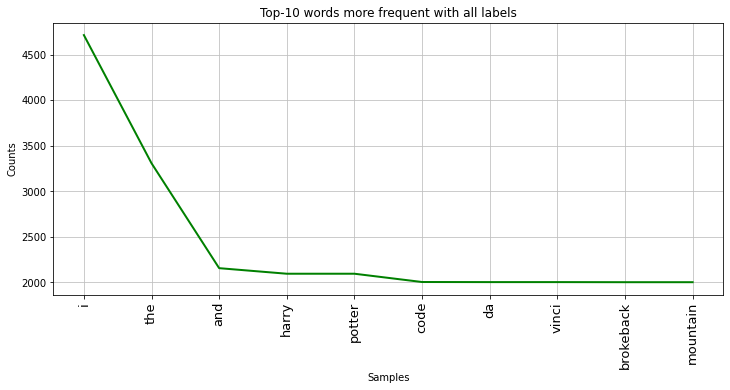

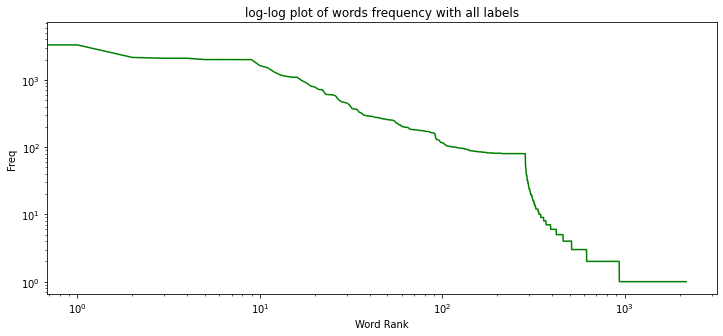

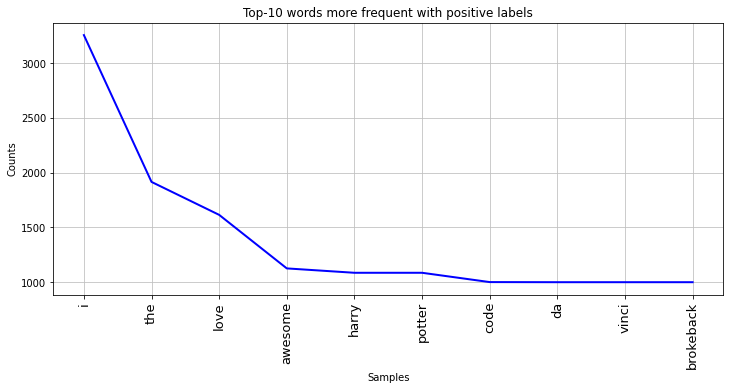

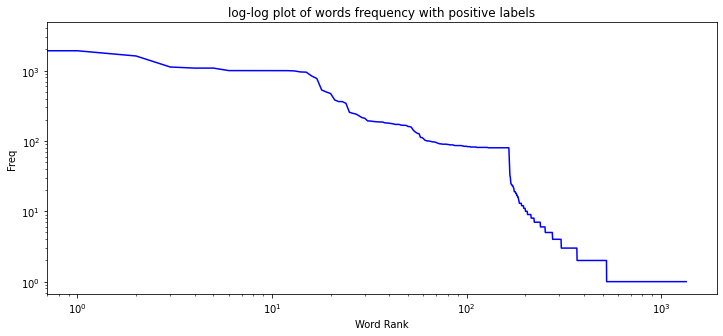

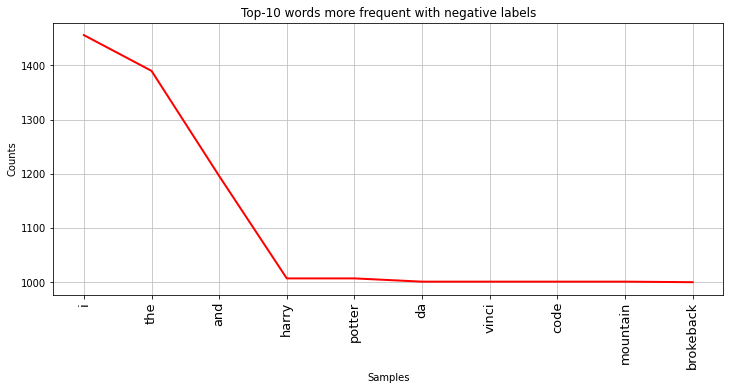

Text(0.5, 1.0, 'log-log plot of words frequency with negative labels')

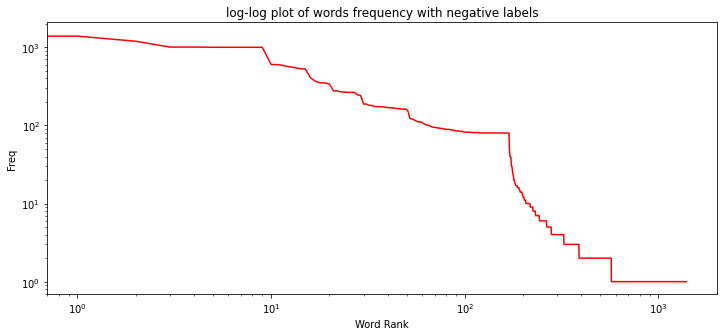

In [21]:
# plot word frequency distribution of first few words
plt.figure(figsize=(12,5))
plt.title('Top-10 words more frequent with all labels')
plt.xticks(fontsize=13, rotation=90)
fd = nltk.FreqDist(all_words)
fd.plot(10,cumulative=False, color="g")

# log-log of all words 
word_counts = sorted(Counter(all_words).values(), reverse=True)
plt.figure(figsize=(12,5))
plt.loglog(word_counts, linestyle='-', linewidth=1.5, color="g")
plt.ylabel("Freq")
plt.xlabel("Word Rank")
plt.title('log-log plot of words frequency with all labels')

# plot word frequency distribution of first few words
plt.figure(figsize=(12,5))
plt.title('Top-10 words more frequent with positive labels')
plt.xticks(fontsize=13, rotation=90)
fd = nltk.FreqDist(pos_words)
fd.plot(10,cumulative=False, color="b")

# log-log of all words 
word_counts = sorted(Counter(pos_words).values(), reverse=True)
plt.figure(figsize=(12,5))
plt.loglog(word_counts, linestyle='-', linewidth=1.5, color="b")
plt.ylabel("Freq")
plt.xlabel("Word Rank")
plt.title('log-log plot of words frequency with positive labels')

# plot word frequency distribution of first few words
plt.figure(figsize=(12,5))
plt.title('Top-10 words more frequent with negative labels')
plt.xticks(fontsize=13, rotation=90)
fd = nltk.FreqDist(neg_words)
fd.plot(10,cumulative=False, color="r")

# log-log of all words 
word_counts = sorted(Counter(neg_words).values(), reverse=True)
plt.figure(figsize=(12,5))
plt.loglog(word_counts, linestyle='-', linewidth=1.5, color="r")
plt.ylabel("Freq")
plt.xlabel("Word Rank")
plt.title('log-log plot of words frequency with negative labels')

## Data Pre-processing 2: Tokenization without Stopwords

In [22]:
def text_process(twitt):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    no_punc = [char for char in twitt if char not in string.punctuation]

    # Join the characters again to form the string.
    no_punc = ''.join(no_punc)
    
    # Now just remove any stopwords
    return [word for word in no_punc.split() if word.lower() not in stopwords.words('english')]

def remove_words(word_list):
    remove = ['harry','potter','code','da','vinci','brokeback','mountain','mission','movie','movies']
    return [w for w in word_list if w not in remove]

In [23]:
twitters.head()

,label,tweet,word count,tweet_preprocess
0,1,The Da Vinci Code book is just awesome.,8,the da vinci code book is just awesome
1,1,this was the first clive cussler i've ever rea...,23,this was the first clive cussler i ve ever rea...
2,1,i liked the Da Vinci Code a lot.,8,i liked the da vinci code a lot
3,1,i liked the Da Vinci Code a lot.,8,i liked the da vinci code a lot
4,1,I liked the Da Vinci Code but it ultimatly did...,15,i liked the da vinci code but it ultimatly did...


In [24]:
twitters['tweet_pp_text_process'] = twitters['tweet_preprocess'].apply(text_process)

In [25]:
twitters.head()

,label,tweet,word count,tweet_preprocess,tweet_pp_text_process
0,1,The Da Vinci Code book is just awesome.,8,the da vinci code book is just awesome,"[da, vinci, code, book, awesome]"
1,1,this was the first clive cussler i've ever rea...,23,this was the first clive cussler i ve ever rea...,"[first, clive, cussler, ever, read, even, book..."
2,1,i liked the Da Vinci Code a lot.,8,i liked the da vinci code a lot,"[liked, da, vinci, code, lot]"
3,1,i liked the Da Vinci Code a lot.,8,i liked the da vinci code a lot,"[liked, da, vinci, code, lot]"
4,1,I liked the Da Vinci Code but it ultimatly did...,15,i liked the da vinci code but it ultimatly did...,"[liked, da, vinci, code, ultimatly, seem, hold]"


In [26]:
twitters['tweet_pp_text_process']

0                        [da, vinci, code, book, awesome]
1       [first, clive, cussler, ever, read, even, book...
2                           [liked, da, vinci, code, lot]
3                           [liked, da, vinci, code, lot]
4         [liked, da, vinci, code, ultimatly, seem, hold]
                              ...                        
6913                        [brokeback, mountain, boring]
6914            [brokeback, mountain, really, depressing]
6915    [sit, watching, mtv, movie, awards, reminded, ...
6916           [ok, brokeback, mountain, horrible, movie]
6917           [oh, brokeback, mountain, terrible, movie]
Name: tweet_pp_text_process, Length: 6918, dtype: object

In [27]:
twitters.head()

,label,tweet,word count,tweet_preprocess,tweet_pp_text_process
0,1,The Da Vinci Code book is just awesome.,8,the da vinci code book is just awesome,"[da, vinci, code, book, awesome]"
1,1,this was the first clive cussler i've ever rea...,23,this was the first clive cussler i ve ever rea...,"[first, clive, cussler, ever, read, even, book..."
2,1,i liked the Da Vinci Code a lot.,8,i liked the da vinci code a lot,"[liked, da, vinci, code, lot]"
3,1,i liked the Da Vinci Code a lot.,8,i liked the da vinci code a lot,"[liked, da, vinci, code, lot]"
4,1,I liked the Da Vinci Code but it ultimatly did...,15,i liked the da vinci code but it ultimatly did...,"[liked, da, vinci, code, ultimatly, seem, hold]"


In [28]:
twitters['tweet_pp_tp_remove_words'] = twitters['tweet_pp_text_process'].apply(remove_words)

In [29]:
twitters.head()

,label,tweet,word count,tweet_preprocess,tweet_pp_text_process,tweet_pp_tp_remove_words
0,1,The Da Vinci Code book is just awesome.,8,the da vinci code book is just awesome,"[da, vinci, code, book, awesome]","[book, awesome]"
1,1,this was the first clive cussler i've ever rea...,23,this was the first clive cussler i ve ever rea...,"[first, clive, cussler, ever, read, even, book...","[first, clive, cussler, ever, read, even, book..."
2,1,i liked the Da Vinci Code a lot.,8,i liked the da vinci code a lot,"[liked, da, vinci, code, lot]","[liked, lot]"
3,1,i liked the Da Vinci Code a lot.,8,i liked the da vinci code a lot,"[liked, da, vinci, code, lot]","[liked, lot]"
4,1,I liked the Da Vinci Code but it ultimatly did...,15,i liked the da vinci code but it ultimatly did...,"[liked, da, vinci, code, ultimatly, seem, hold]","[liked, ultimatly, seem, hold]"


In [30]:
# most common words in twitter dataset
all_words = []
for ls in twitters['tweet_pp_tp_remove_words']:
    words = [w for w in ls]
    for word in words:
        all_words.append(word.lower())
        
# most common words in twitter dataset
pos_words = []
for ls in twitters['tweet_pp_tp_remove_words'][twitters.label == 1]:
    pwords = [w for w in ls]
    for pword in pwords:
        pos_words.append(pword.lower())        

# most common words in twitter dataset
neg_words = []
for ls in twitters['tweet_pp_tp_remove_words'][twitters.label == 0]:
    nwords = [w for w in ls]
    for nword in nwords:
        neg_words.append(nword.lower())       

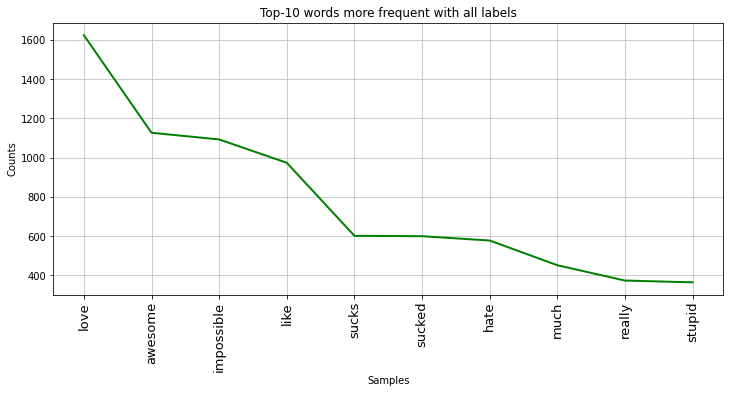

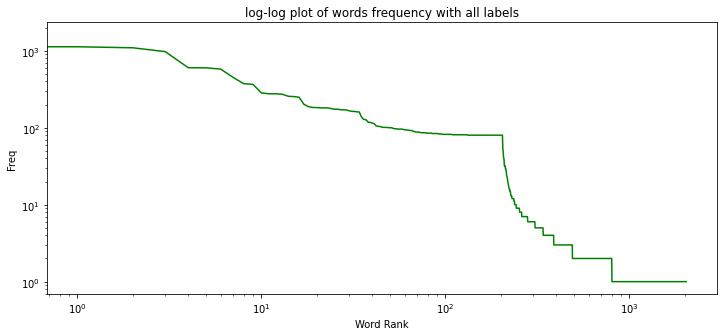

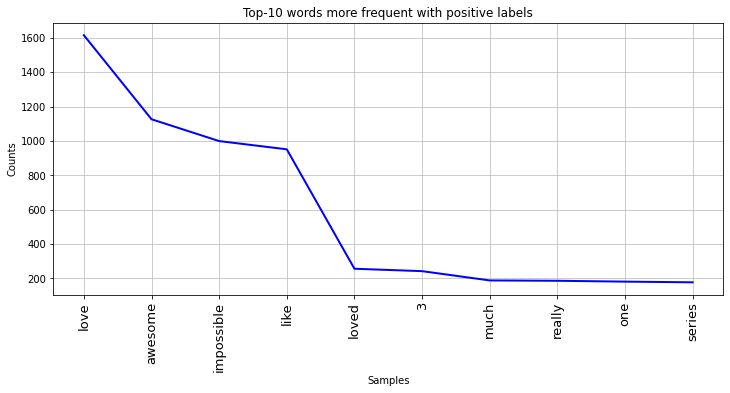

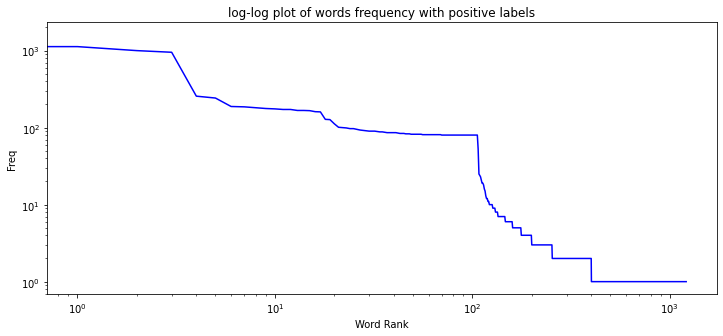

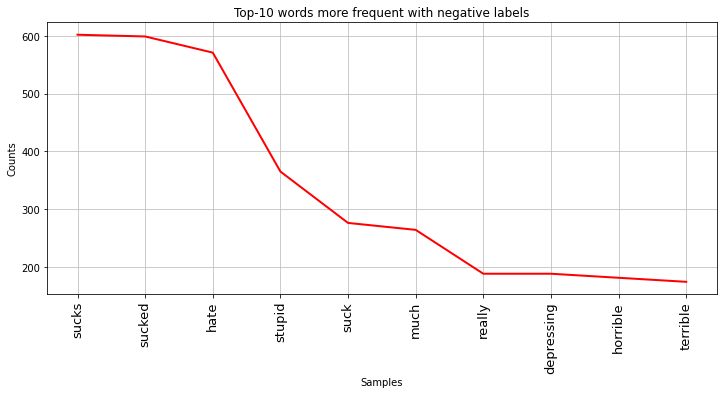

Text(0.5, 1.0, 'log-log plot of words frequency with negative labels')

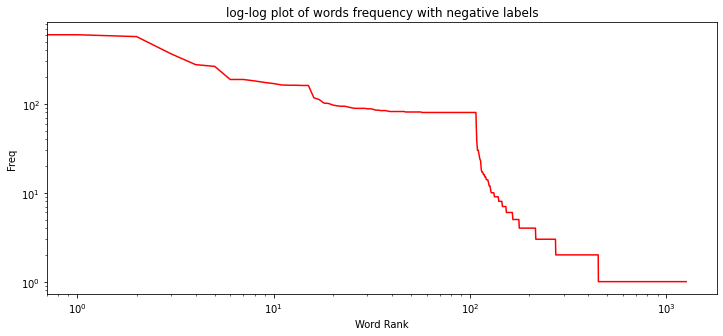

In [31]:
# plot word frequency distribution of first few words
plt.figure(figsize=(12,5))
plt.title('Top-10 words more frequent with all labels')
plt.xticks(fontsize=13, rotation=90)
fd = nltk.FreqDist(all_words)
fd.plot(10,cumulative=False, color="g")

# log-log of all words 
word_counts = sorted(Counter(all_words).values(), reverse=True)
plt.figure(figsize=(12,5))
plt.loglog(word_counts, linestyle='-', linewidth=1.5, color="g")
plt.ylabel("Freq")
plt.xlabel("Word Rank")
plt.title('log-log plot of words frequency with all labels')

# plot word frequency distribution of first few words in positive labels
plt.figure(figsize=(12,5))
plt.title('Top-10 words more frequent with positive labels')
plt.xticks(fontsize=13, rotation=90)
fd = nltk.FreqDist(pos_words)
fd.plot(10,cumulative=False, color="b")

# log-log of all words in positive labels
word_counts = sorted(Counter(pos_words).values(), reverse=True)
plt.figure(figsize=(12,5))
plt.loglog(word_counts, linestyle='-', linewidth=1.5, color="b")
plt.ylabel("Freq")
plt.xlabel("Word Rank")
plt.title('log-log plot of words frequency with positive labels')

# plot word frequency distribution of first few words in negative labels
plt.figure(figsize=(12,5))
plt.title('Top-10 words more frequent with negative labels')
plt.xticks(fontsize=13, rotation=90)
fd = nltk.FreqDist(neg_words)
fd.plot(10,cumulative=False, color="r")

# log-log of all words in negative labels
word_counts = sorted(Counter(neg_words).values(), reverse=True)
plt.figure(figsize=(12,5))
plt.loglog(word_counts, linestyle='-', linewidth=1.5, color="r")
plt.ylabel("Freq")
plt.xlabel("Word Rank")
plt.title('log-log plot of words frequency with negative labels')

## Pre-processing 3: Feature Extraction (Vectorization - Bag of Words)

In [32]:
bagofwords_transformer = CountVectorizer(analyzer=text_process).fit(twitters['tweet'])

In [33]:
print(len(bagofwords_transformer.vocabulary_))

2350


In [34]:
twitters['tweet']

0                 The Da Vinci Code book is just awesome.
1       this was the first clive cussler i've ever rea...
2                        i liked the Da Vinci Code a lot.
3                        i liked the Da Vinci Code a lot.
4       I liked the Da Vinci Code but it ultimatly did...
                              ...                        
6913                       Brokeback Mountain was boring.
6914         So Brokeback Mountain was really depressing.
6915    As I sit here, watching the MTV Movie Awards, ...
6916      Ok brokeback mountain is such a horrible movie.
6917     Oh, and Brokeback Mountain was a terrible movie.
Name: tweet, Length: 6918, dtype: object

In [35]:
tweet5 = twitters['tweet'][4]

In [36]:
print(tweet5)

I liked the Da Vinci Code but it ultimatly didn't seem to hold it's own.


In [37]:
bow5 = bagofwords_transformer.transform([tweet5])
print(bow5)
print(bow5.shape)

  (0, 151)	1
  (0, 180)	1
  (0, 634)	1
  (0, 1051)	1
  (0, 1388)	1
  (0, 1549)	1
  (0, 1947)	1
  (0, 2207)	1
(1, 2350)


In [38]:
print(bagofwords_transformer.get_feature_names()[519])
print(bagofwords_transformer.get_feature_names()[1037])
print(bagofwords_transformer.get_feature_names()[634])
print(bagofwords_transformer.get_feature_names()[1051])
print(bagofwords_transformer.get_feature_names()[1388])
print(bagofwords_transformer.get_feature_names()[1549])
print(bagofwords_transformer.get_feature_names()[1947])
print(bagofwords_transformer.get_feature_names()[2207])

Rickards
delicious
Vinci
didnt
hold
liked
seem
ultimatly


In [39]:
twitters_bow = bagofwords_transformer.transform(twitters['tweet'])

In [40]:
print('Shape of Sparse Matrix: ', twitters_bow.shape)
print('Amount of Non-Zero occurences: ', twitters_bow.nnz)

Shape of Sparse Matrix:  (6918, 2350)
Amount of Non-Zero occurences:  46028


In [41]:
sparsity = (100.0 * twitters_bow.nnz / (twitters_bow.shape[0] * twitters_bow.shape[1]))
print('sparsity: {}'.format(round(sparsity)))

sparsity: 0


### TF-IDF

In [42]:
tfidf_transformer = TfidfTransformer().fit(twitters_bow)
tfidf5 = tfidf_transformer.transform(bow5)
print(tfidf5)

  (0, 2207)	0.49164560211161784
  (0, 1947)	0.49164560211161784
  (0, 1549)	0.2808852599058391
  (0, 1388)	0.4698565796960789
  (0, 1051)	0.4000352670868803
  (0, 634)	0.137309529420294
  (0, 180)	0.13734632390404936
  (0, 151)	0.13842447276291386


In [43]:
print(tfidf_transformer.idf_[bagofwords_transformer.vocabulary_['code']])
print(tfidf_transformer.idf_[bagofwords_transformer.vocabulary_['code']])

3.7217291105478605
3.7217291105478605


In [44]:
twitters_tfidf = tfidf_transformer.transform(twitters_bow)
print(twitters_tfidf.shape)

(6918, 2350)


## Training a model

In [45]:
sentiment_detect_model = MultinomialNB().fit(twitters_tfidf, twitters['label'])

In [46]:
print('predicted:', sentiment_detect_model.predict(tfidf5)[0])
print('actual:', twitters['label'][4])

predicted: 1
actual: 1


## Train Test Split

In [47]:
twt_train, twt_test, label_train, label_test = \
train_test_split(twitters['tweet'], twitters['label'], test_size=0.3)

print('train size:', len(twt_train))
print('test size:', len(twt_test))
print('dataset size:', len(twt_train) + len(twt_test))

train size: 4842
test size: 2076
dataset size: 6918


## Creating a Data Pipeline

In [48]:
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [49]:
pipeline.fit(twt_train,label_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x000001F0287AFEE0>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

## Model Evaluation

In [50]:
predictions = pipeline.predict(twt_test)

In [51]:
print(classification_report(predictions,label_test))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98       885
           1       0.99      0.97      0.98      1191

    accuracy                           0.98      2076
   macro avg       0.98      0.98      0.98      2076
weighted avg       0.98      0.98      0.98      2076



In [52]:
cf_matrix = confusion_matrix(predictions,label_test)


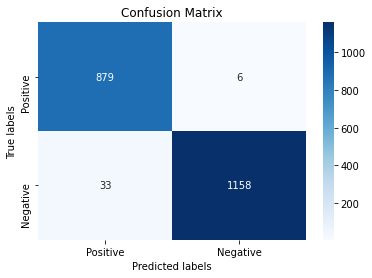

In [53]:
ax= plt.subplot()
#annot=True to annotate cells
sns.heatmap(cf_matrix, annot=True, ax = ax,cmap='Blues',fmt='');

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['Positive', 'Negative']); ax.yaxis.set_ticklabels(['Positive', 'Negative']);

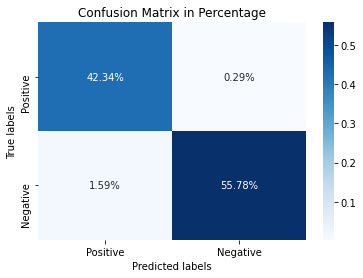

In [67]:
ax= plt.subplot()
#annot=True to annotate cells
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, ax = ax,cmap='Blues', fmt='.2%');

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix in Percentage');
ax.xaxis.set_ticklabels(['Positive', 'Negative']); ax.yaxis.set_ticklabels(['Positive', 'Negative']);

## Evaluation on split testdataset

In [55]:
predictions

array([0, 1, 1, ..., 1, 1, 0], dtype=int64)

In [56]:
twt_test_noindex = twt_test.reset_index(drop=True)
print(twt_test_noindex)

0        Oh, and Brokeback Mountain was a terrible movie.
1       I like Mission Impossible movies because you n...
2                          The Da Vinci Code is awesome..
3                Brokeback Mountain is fucking horrible..
4                                    I LOVE Harry Potter.
                              ...                        
2071    I want to be here because I love Harry Potter,...
2072            I hear that The Da Vinci Code sucked too.
2073            The Da Vinci Code was absolutely AWESOME!
2074                                I love Harry Potter..
2075                   The Da Vinci Code sucked big time.
Name: tweet, Length: 2076, dtype: object


In [57]:
twt_test_noindex[0]

'Oh, and Brokeback Mountain was a terrible movie.'

In [58]:
for i, p in enumerate(predictions):
#     print(i)
    print (twt_test_noindex[i] + " - " + str(p))
    if i>5:
        break #to avoid a lot of printing and slowing down the notebook

Oh, and Brokeback Mountain was a terrible movie. - 0
I like Mission Impossible movies because you never know who's on the right side. - 1
The Da Vinci Code is awesome.. - 1
Brokeback Mountain is fucking horrible.. - 0
I LOVE Harry Potter. - 1
Which is why i said silent hill turned into reality coz i was hella like goin mission impossible down that bitch. - 1
The Da Vinci Code is awesome!! - 1


## Test on Dataset.txt (no label)

In [59]:
twitters_test = pd.read_csv('testdata.txt', sep = '\t', names=['tweet'])

In [60]:
twitters_test

,tweet
0,"I don't care what anyone says, I like Hillary..."
1,"harvard is dumb, i mean they really have to be..."
2,I'm loving Shanghai > > > ^ _ ^.
3,harvard is for dumb people.
4,"As i stepped out of my beautiful Toyota, i hea..."
...,...
28932,Love Story At Harvard [ awesome drama!
28933,"well, i had a piece of crap toyota celica but ..."
28934,But I miss Boston.
28935,i love paris hilton..


In [61]:
twitters_test['tweet']

0         I don't care what anyone says, I like Hillary...
1        harvard is dumb, i mean they really have to be...
2                         I'm loving Shanghai > > > ^ _ ^.
3                              harvard is for dumb people.
4        As i stepped out of my beautiful Toyota, i hea...
                               ...                        
28932               Love Story At Harvard [ awesome drama!
28933    well, i had a piece of crap toyota celica but ...
28934                                   But I miss Boston.
28935                                i love paris hilton..
28936    I was rejected by the stupid San Francisco lit...
Name: tweet, Length: 28937, dtype: object

In [62]:
twitters_test_noindex = twitters_test['tweet'].reset_index(drop=True)
print(twitters_test_noindex)

0         I don't care what anyone says, I like Hillary...
1        harvard is dumb, i mean they really have to be...
2                         I'm loving Shanghai > > > ^ _ ^.
3                              harvard is for dumb people.
4        As i stepped out of my beautiful Toyota, i hea...
                               ...                        
28932               Love Story At Harvard [ awesome drama!
28933    well, i had a piece of crap toyota celica but ...
28934                                   But I miss Boston.
28935                                i love paris hilton..
28936    I was rejected by the stupid San Francisco lit...
Name: tweet, Length: 28937, dtype: object


In [63]:
predictions_nolabel = pipeline.predict(twitters_test['tweet'])

In [64]:
predictions_nolabel

array([1, 1, 0, ..., 1, 1, 0], dtype=int64)

In [65]:
twitters_test_noindex

0         I don't care what anyone says, I like Hillary...
1        harvard is dumb, i mean they really have to be...
2                         I'm loving Shanghai > > > ^ _ ^.
3                              harvard is for dumb people.
4        As i stepped out of my beautiful Toyota, i hea...
                               ...                        
28932               Love Story At Harvard [ awesome drama!
28933    well, i had a piece of crap toyota celica but ...
28934                                   But I miss Boston.
28935                                i love paris hilton..
28936    I was rejected by the stupid San Francisco lit...
Name: tweet, Length: 28937, dtype: object

In [66]:
for j, k in enumerate(predictions_nolabel):
#     print(i)
    print (twitters_test_noindex[j] + " - " + str(k))
    if j>10:
        break #to avoid a lot of printing and slowing down the notebook

 I don't care what anyone says, I like Hillary Clinton.
have an awesome time at purdue!..
Yep, I'm still in London, which is pretty awesome: P Remind me to post the million and one pictures that I took when I get back to Markham!...
Have to say, I hate Paris Hilton's behavior but I do think she's kinda cute..
i will love the lakers.
I'm so glad I love Paris Hilton, too, or this would be excruciating.
considering most Geico commericals are stupid...
i liked MIT though, esp their little info book(
Before I left Missouri, I thought London was going to be so good and cool and fun and a really great experience and I was really excited.
I still like Tom Cruise.
well, i had a piece of crap toyota celica but it died in portland and i got a ford ranger..
i love angelina jolie.
I still like Tom Cruise.
UCLA is beautiful.
I think Angelina Jolie is so much more beautiful than Jennifer Anniston, who, by the way, is majorly OVERRATED.
Angelina Jolie is beautiful.
and honda's are awesome:).
I love Ha